### This notebook includes the entire pipeline for the analysis after the necessary preprocessing that creates a (2040, 2639) feature matrix. At a high level, this notebook tunes a given classifier for predicting whether a speech recording is indicative of a speech disorder (0: Benign, 1: Anomalous). Then, the tuned classifier is used to predict instances within the test (hold out) set. ROC curves, Precision, Recall, and F-1 scores are also calculated outside of accuracy. Lastly, we interpret the constructed model through permutation importance, shapley importance, and partial dependency plots.

### Note: The results of the RCEFV with a simple random forests classifier are not shown here (a simple subset is created based on the results in the second code cell), although the process was a straightforward recursive feature elimination using a random forests model with default hyperparameters and step size of 1. Additionally, feature pruning based on correlation is conducted only to better improve interpretability (e.g., permutation feature importance is heavily influenced by highly correlated features). This additional reduction of features based on collinearity allows for better interpretability of the model at the cost of a slight predictive capability decrease.

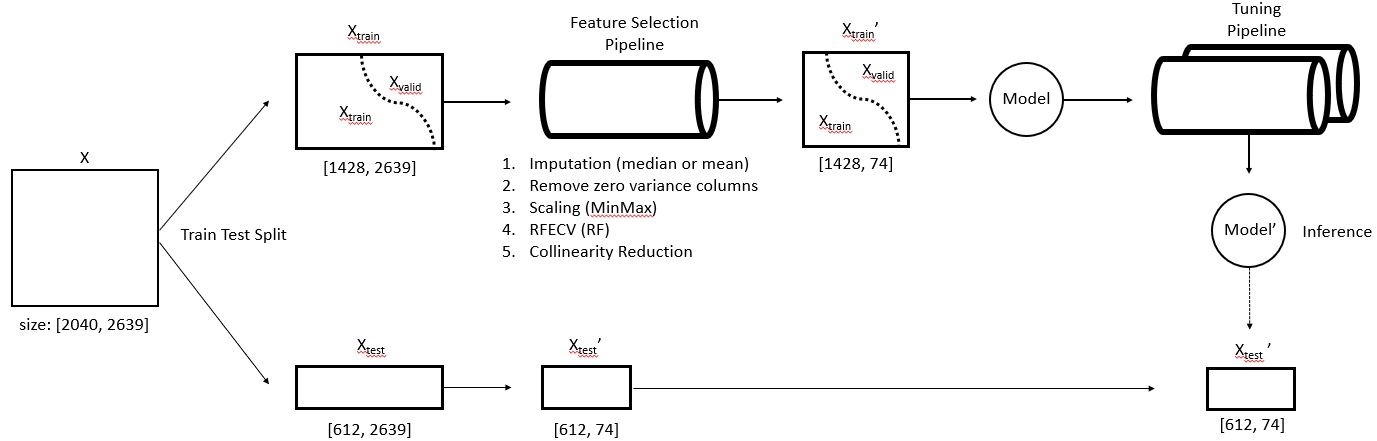

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, RFECV
from sklearn.metrics import accuracy_score, classification_report
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from pylab import rcParams
from sklearn.impute import KNNImputer

rcParams['figure.figsize'] = 10, 10
rcParams['figure.dpi'] = 300
rcParams['font.size'] = 10

#### Read in data, and then subset based on RFECV results using a default RandomForestClassifier(). Import data and drop a few features.

In [2]:
X = pd.read_csv(r'C:\Users\esabic\Desktop\Refactor_Attempts_11_4\Raw_Features_Complete_11_19\Complete_Feature_Set_11_19_2.csv')
y, age, sex, recording_num = X['y'], X['age'], X['sex'], X['recording_num']
X = X.drop(['y','age','sex','recording_num'], axis = 1)
num_feats_prior = X.shape[1]

rfecv_subset = pd.read_csv(r'C:\Users\esabic\Desktop\Refactor_Attempts_11_4\Raw_Features_Complete_11_19\RFECV_Results_12_8.csv')
X = X.loc[:, rfecv_subset.columns]
num_feats_after = X.shape[1]
print('Total number of features dropped was... ', num_feats_prior - num_feats_after, '\nRemaining features... ', num_feats_after)

Total number of features dropped was...  2535 
Remaining features...  104


#### Assess correlation between features, and drop individual features if they correlate highly (r > .75 chosen here) with any other features.

In [3]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
X = X.drop(X[to_drop], axis=1)
print('Total number of features dropped was...', num_feats_after - X.shape[1], '\nRemaining features... ', X.shape[1])
print(X.columns)

Total number of features dropped was... 29 
Remaining features...  75
Index(['stdev_period', 'stdev_mfcc_7', 'mean_slope_Mel', 'mean_harmony',
       'Jitter_loc_h_a', 'mean_slope_Mel_h_a', 'Jitter_rap_lhl_a',
       'mean_mfcc_2_lhl_a', 'mean_mfcc_7_lhl_a', 'stdev_mfcc_2_lhl_a',
       'stdev_onset_env_lhl_a', 'stdev_pitches_lhl_a', 'meanF0_n_a',
       'mean_mfcc_8_n_a', 'lpc1_n_a', 'mean_slope_Mel_n_a', 'Spec_Power_2_n_a',
       'Jitter_loci_features', 'apq11Shimmeri_features',
       'mean_magnitudesi_features', 'mean_chroma_4i_features',
       'sd_chroma_4i_features', 'mean_slope_Hzi_features', 'mean_mfcc_6_h_i',
       'mean_magnitudes_h_i', 'mean_slope_Hz_h_i', 'mean_mfcc_9_lhl_i',
       'mean_magnitudes_lhl_i', 'mean_harmony_lhl_i', 'mean_chroma_0_n_i',
       'mean_slope_Mel_n_i', 'stdev_periodu_features', 'mean_mfcc_4u_features',
       'mean_slope_Hzu_features', 'mean_slope_Mel_h_u', 'mean_mfcc_4_lhl_u',
       'mean_onset_env_lhl_u', 'sd_mfcc_delta_5_lhl_u',
       'sd_m

In [5]:
X = X.drop('high_indexphrase_features', axis = 1)

(2040, 75)
(2040, 74)


In [7]:
X.columns = ['Stdev Period l-a', 'Stdev MFCC-7 l-a', 'Mean Slope Melspec l-a', 'Mean Harmonicity l-a', 'Jitter (loc) h-a',
'Mean Slope Melspec h-a', 'Jitter (rap) lhl-a', 'Mean MFCC-2 lhl-a', 'Mean MFCC-7 lhl-a', 
'Stdev MFCC-2 lhl-a', 'Stdev Onset Envelope lhl-a', 'Stdev Pitches lhl-a', 'Mean Frequency n-a',
'Mean MFCC-8 n-a', 'LPC-1 n-a', 'Mean Slope Melspec n-a', 'Spec Power 1000Hz .25s n-a',
'Jitter (loc) l-i', 'Shimmer (apq11) l-i', 'Mean Magnitudes l-i', 'Mean Chromagram-4 l-i', 'Stdev Chromagram-4 l-i',
'Mean Slope (Hz) l-i', 'Mean MFCC-6 h-i', 'Mean Magnitudes h-i', 'Mean Slope (Hz) h-i', 'Mean MFCC-9 lhl-i',
'Mean Magnitudes lhl-i', 'Mean Harmony lhl-i', 'Mean Chromagram-0 n-i', 'Mean Slope Melspec n-i', 'Stdev Period l-u',
'Mean MFCC-4 l-u', 'Mean Slope (Hz) l-u', 'Mean Slope Melspec h-u', 'Mean MFCC-4 lhl-u', 'Mean Onset Envelope lhl-u',
'Stdev MFCC Delta-5 lhl-u', 'Stdev MFCC Delta-10 lhl-u', 'Stdev Period n-u', 'Mean Slope (Hz) n-u', 'HNR Phrases',
'Count of Periods Phrases', 'Mean MFCC-2 Phrases', 'Mean MFCC Delta-3 Phrases', 'Mean MFCC Delta-4 Phrases', 
'Mean MFCC Delta-11 Phrases', 'Stdev MFCC-2 Phrases', 'Stdev Onset Envelope Phrases', 'Max RMS Phrases',
'Stdev MFCC Delta-3 Phrases', 'Stdev MFCC Delta-7 Phrases', 'Spec Power 1000Hz .25s Phrases',
'Spec Power 1000Hz .5s Phrases','Spec Power 1000Hz .75s Phrases', 'CPPS Phrases', 'LSF-0 l-a', 
'Spectral Flux Stdev lhl-a', 'Spectral Spread Mean lhl-a', 'Spectral Spread Mean n-i',
'Shannon Entropy Sliding Window First Deriv Stdev n-i', 'f2 l-i', 'Spectral Skewness Mean h-i', 'Crest Factor Mean n-u',
'Pitch Period Entropy l-u', 'Spectral Flux First Deriv Mean Phrases', 'Spectral Entropy First Deriv Stdev Phrases',
'Spectral Spread Mean Phrases', 'Spectral Skewness First Deriv Stdev Phrases', 'Spectral Flatness Stdev Phrases', 
'Spectral Rolloff Stdev Phrases', 'Pitch Period Entropy Phrases', 'LPC-4 Phrases', 'Kurtosis Sliding Window First Deriv Mean Phrases']

#### Split data and conduct an initial fit prior to hyperparameter tuning.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, stratify = y, random_state = 42)

classifier = SVC()

test_pipeline = Pipeline([('variance_pruning', VarianceThreshold()),
                ('imputer', KNNImputer()), 
                ('scaler', MinMaxScaler()),
                ('model', classifier)])

test_pipeline.fit(X_train, y_train)
print(classification_report(y_test, test_pipeline.predict(X_test), target_names = ['benign','anomalous'], digits = 4))

              precision    recall  f1-score   support

      benign     0.7590    0.7184    0.7382       206
   anomalous     0.8609    0.8842    0.8724       406

    accuracy                         0.8284       612
   macro avg     0.8099    0.8013    0.8053       612
weighted avg     0.8266    0.8284    0.8272       612



#### Conducted hyperparameter tuning using RandomizedSearchCV and the already constructed pipeline. 

In [11]:
search_space = [{'model': [SVC()],
                 'model__C': [.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5],
                 'model__kernel': ['linear','poly','rbf','sigmoid','precomputed'],
                 'model__degree': [3, 4, 5],
                 'model__gamma': ['scale', 'auto'],
                 'model__probability':[True]}]

clf = RandomizedSearchCV(test_pipeline, search_space, cv = 5, verbose = 0, n_jobs = -1,\
                        scoring = 'roc_auc', n_iter = 50) 

clf = clf.fit(X_train, y_train) 

print('Best score of a given tuned classifier during the randomized search...', clf.best_score_*100)

C:\Users\esabic\Anaconda3\envs\gpu_environment\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.8644042         nan 0.85214535 0.87850175 0.86868725 0.86529165
        nan 0.86930066 0.65732171 0.87942861 0.85616859 0.87972706
 0.88463085 0.87972706 0.86206463 0.67315941 0.86233816        nan
 0.85229876 0.87976348 0.88438261 0.87906645 0.88444732 0.86684757
        nan 0.87961566 0.86205338 0.87972706 0.84420846 0.8716652
 0.88371753        nan        nan 0.87972706        nan 0.66770693
        nan 0.74561378 0.87335734        nan        nan 0.86222684
 0.8173056  0.84521555 0.85207864 0.86595921 0.87533845 0.86205332
 0.85221092 0.88339164]
  category=UserWarning


Best score of a given tuned classifier during the randomized search... 88.46308539341862


#### Fetch best estimator found during the tuning process, and finally use this estimator to predict cases in the testing set. Calculate precision, recall, and f1-score across the two classes.

In [12]:
tuned_clf = clf.best_estimator_

print(classification_report(y_test, tuned_clf.predict(X_test), target_names = ['benign','anomalous'], digits = 4))
print(accuracy_score(y_test, tuned_clf.predict(X_test)))

              precision    recall  f1-score   support

      benign     0.7563    0.7233    0.7395       206
   anomalous     0.8627    0.8818    0.8721       406

    accuracy                         0.8284       612
   macro avg     0.8095    0.8025    0.8058       612
weighted avg     0.8269    0.8284    0.8275       612

0.8284313725490197


In [13]:
print(clf.best_params_)

{'model__probability': True, 'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__degree': 4, 'model__C': 4, 'model': SVC(C=4, degree=4, probability=True)}


#### Create a receiver operating characteristic (ROC) curve and derive area under the curve (AUC).

C:\Users\esabic\Anaconda3\envs\gpu_environment\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<function matplotlib.pyplot.show(*args, **kw)>

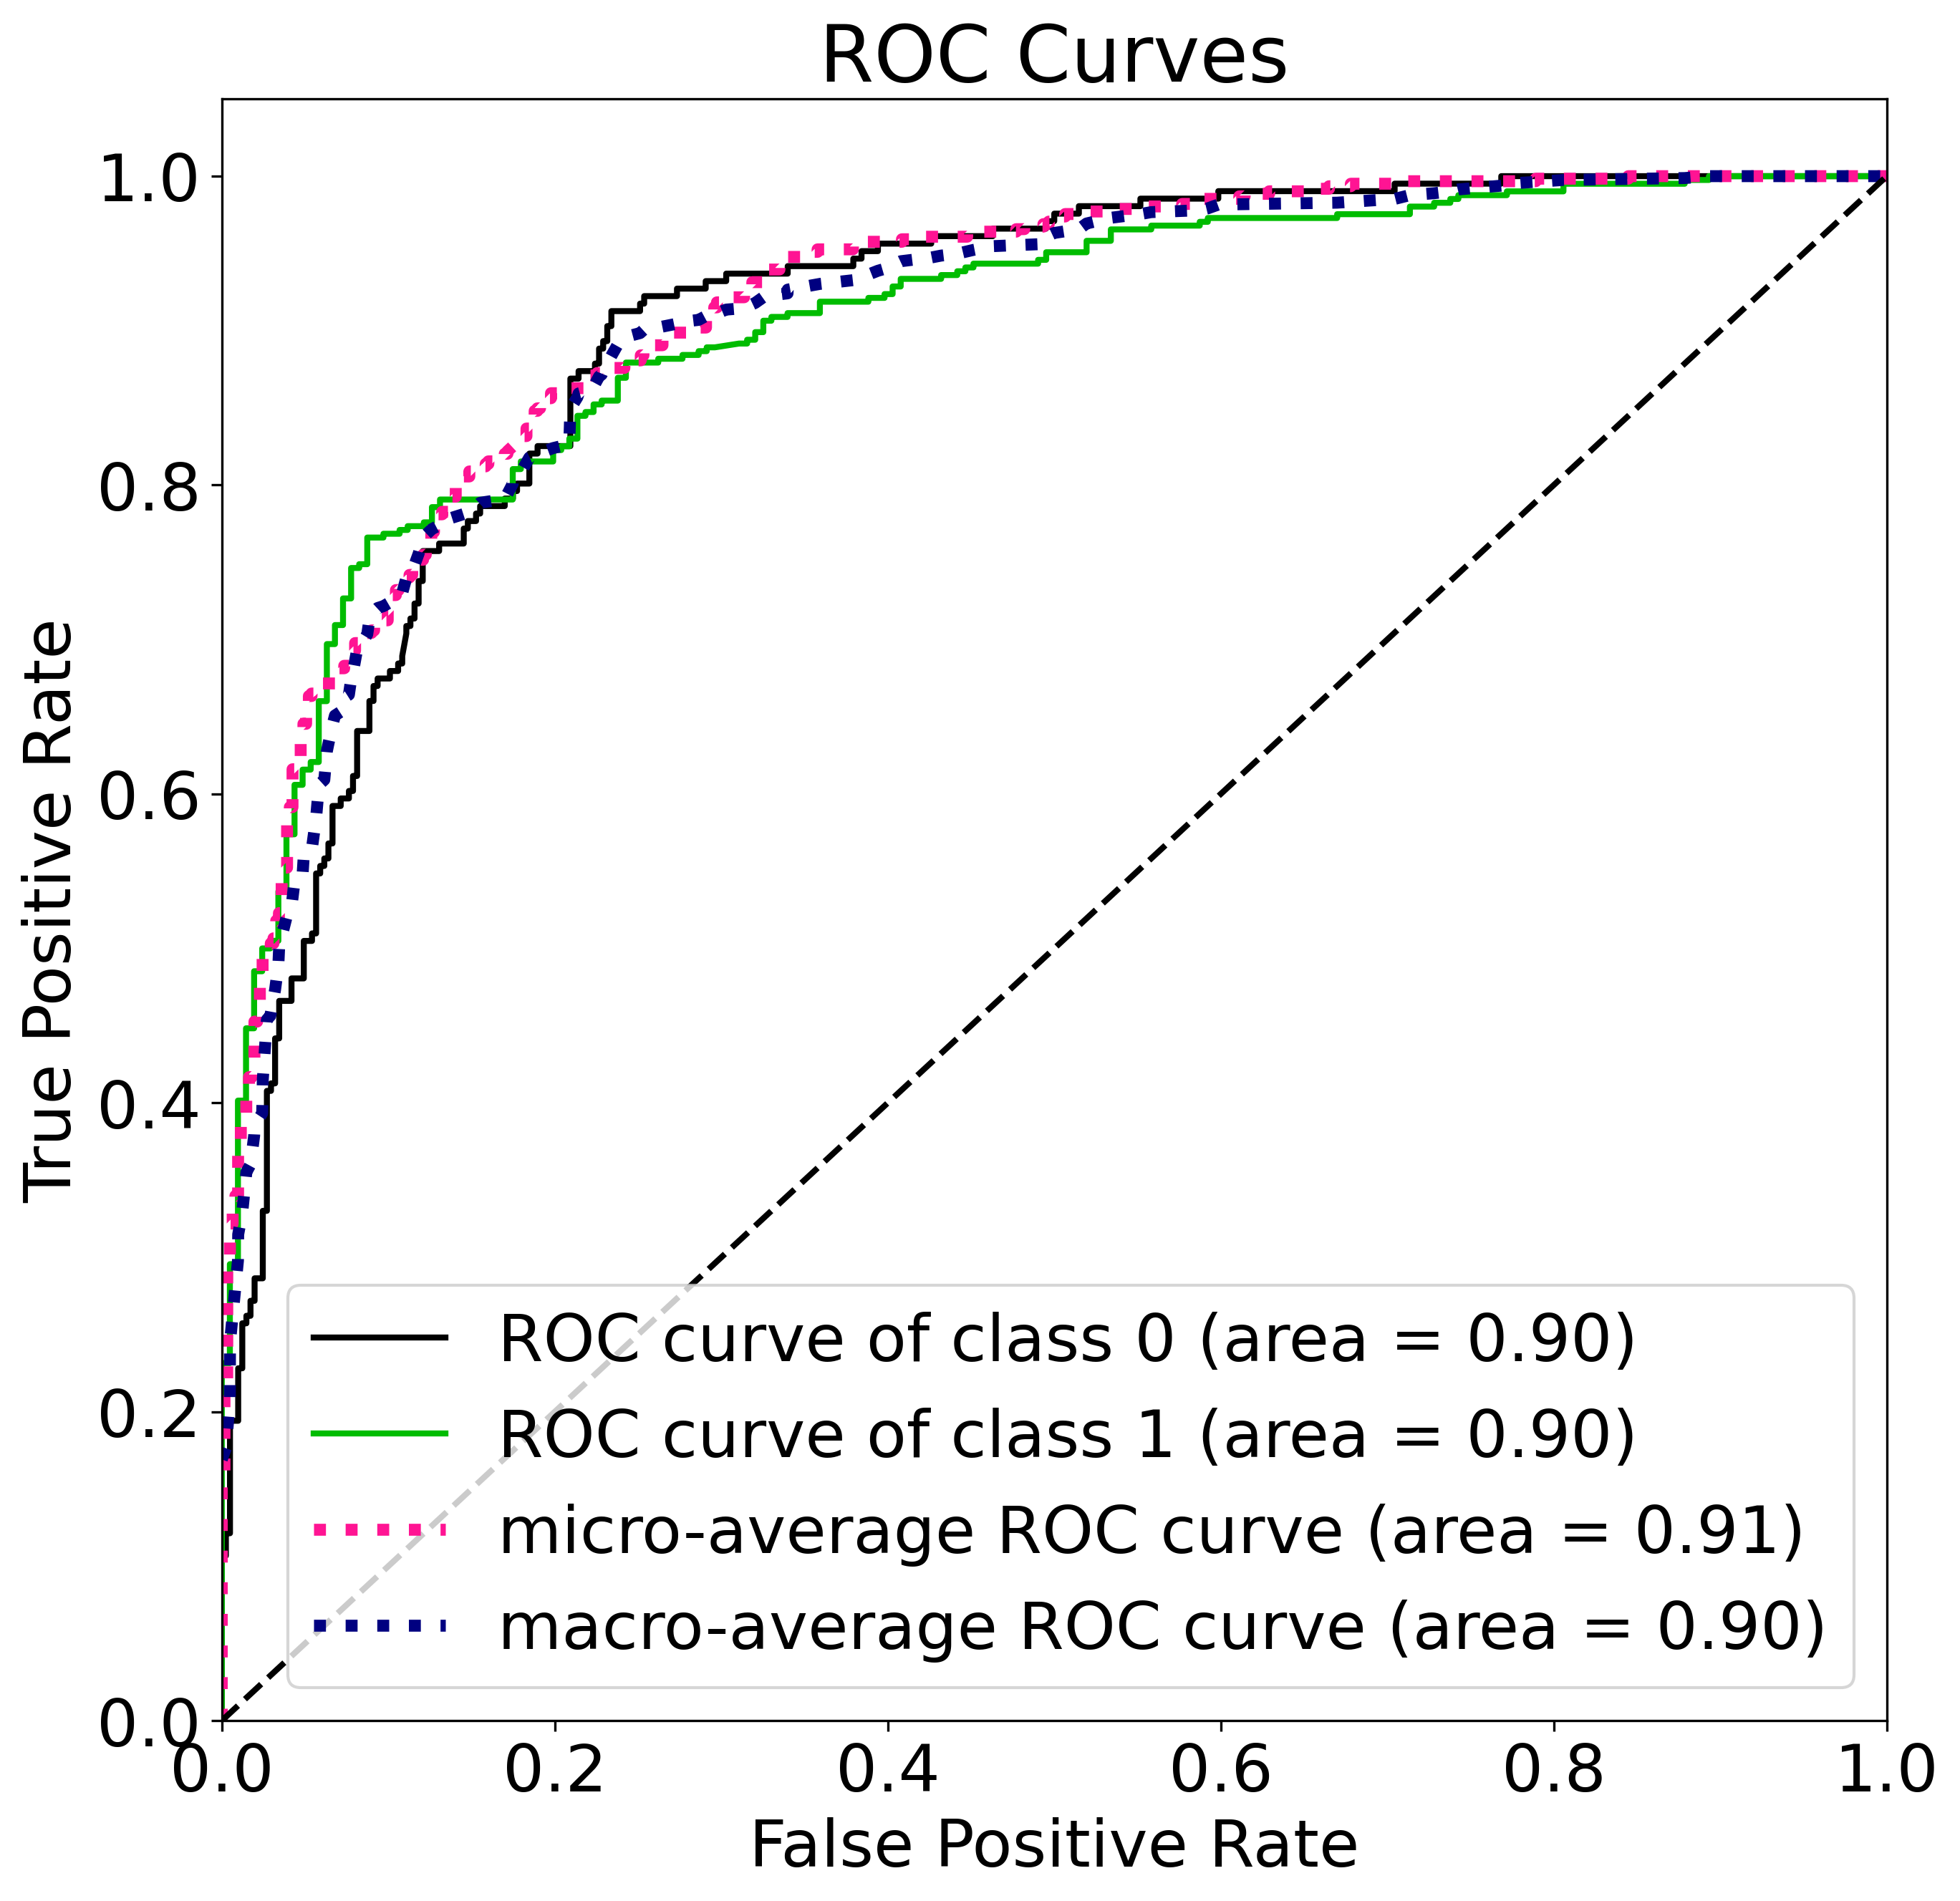

In [14]:
import sklearn.metrics as metrics
import scikitplot as skplt
import matplotlib.pyplot as plt

rcParams['font.size'] = 22

y_true = y_test
y_probas = tuned_clf.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show

#### Conduct permutation importance, Shapley-based importance, and create partial dependency plots using the highly influential features.

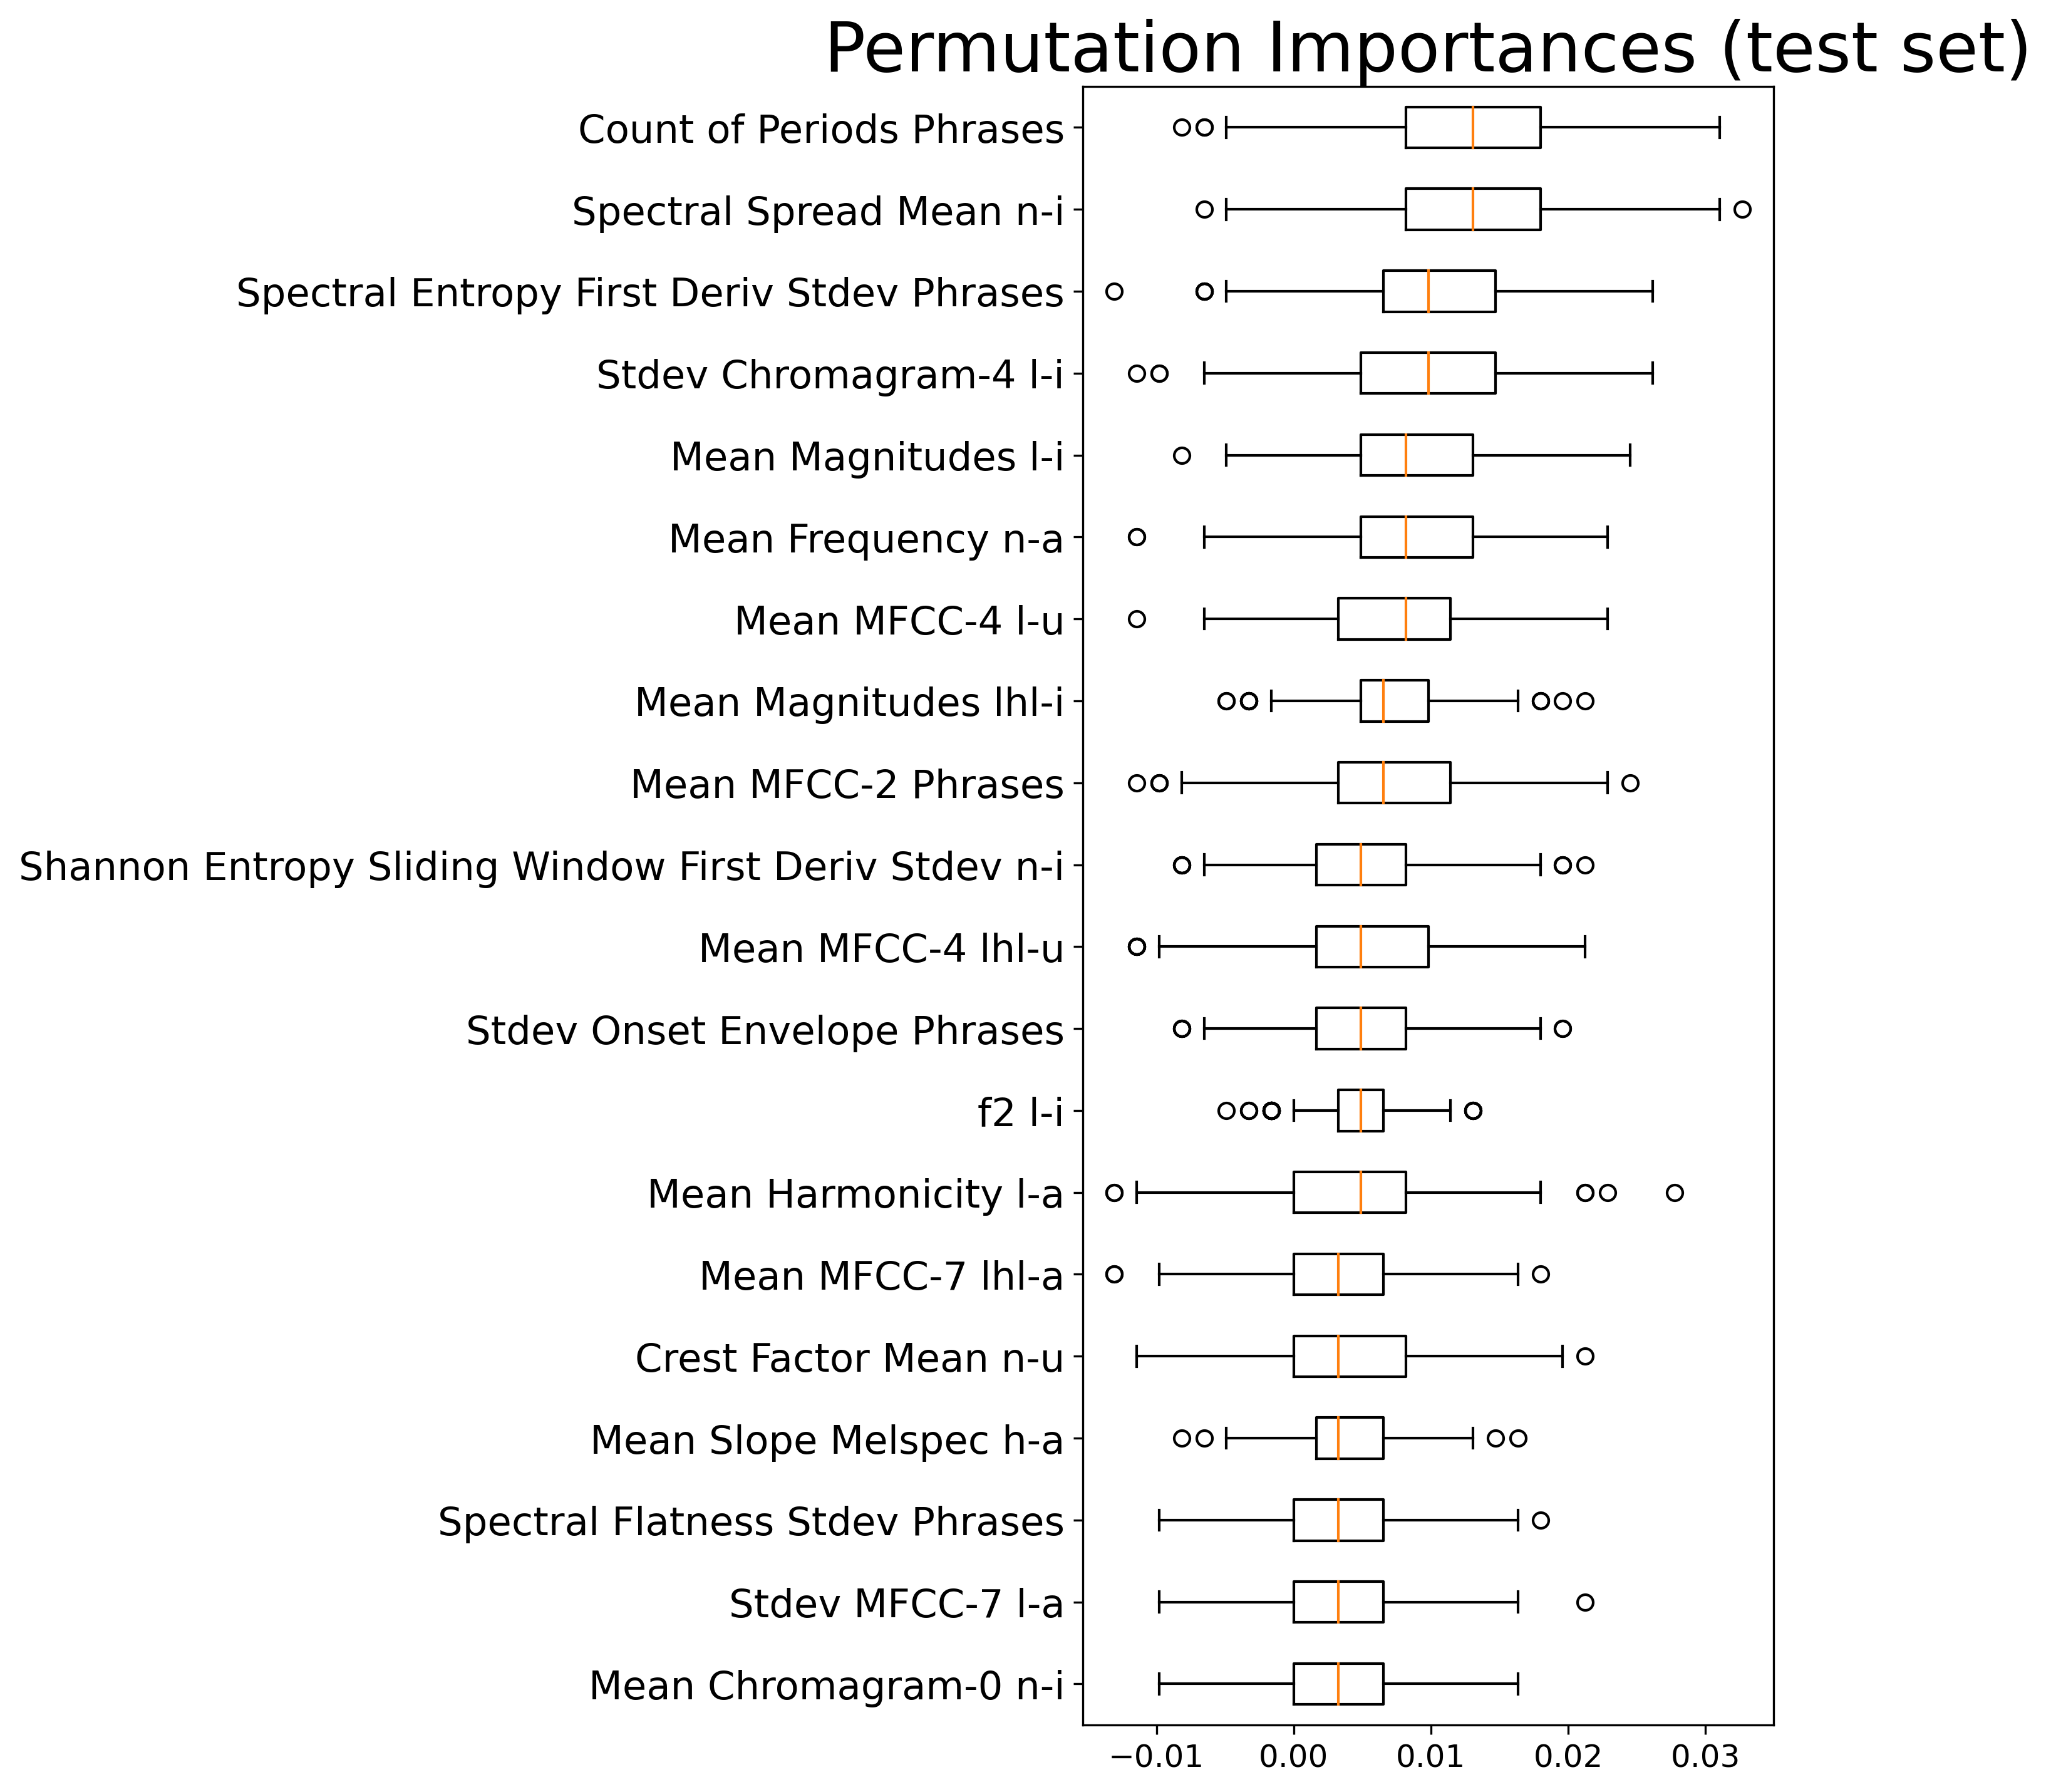

In [15]:
import matplotlib
from sklearn.inspection import permutation_importance

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=15) 

result = permutation_importance(tuned_clf, X_test, y_test, n_repeats = 500, 
                                random_state = 42, n_jobs = -1)

sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots()

ax.boxplot(result.importances[sorted_idx][-20:].T,
           vert=False, labels=X_test.columns[sorted_idx][-20:])

ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

Permutation explainer: 613it [01:49,  5.21it/s]                                                                        


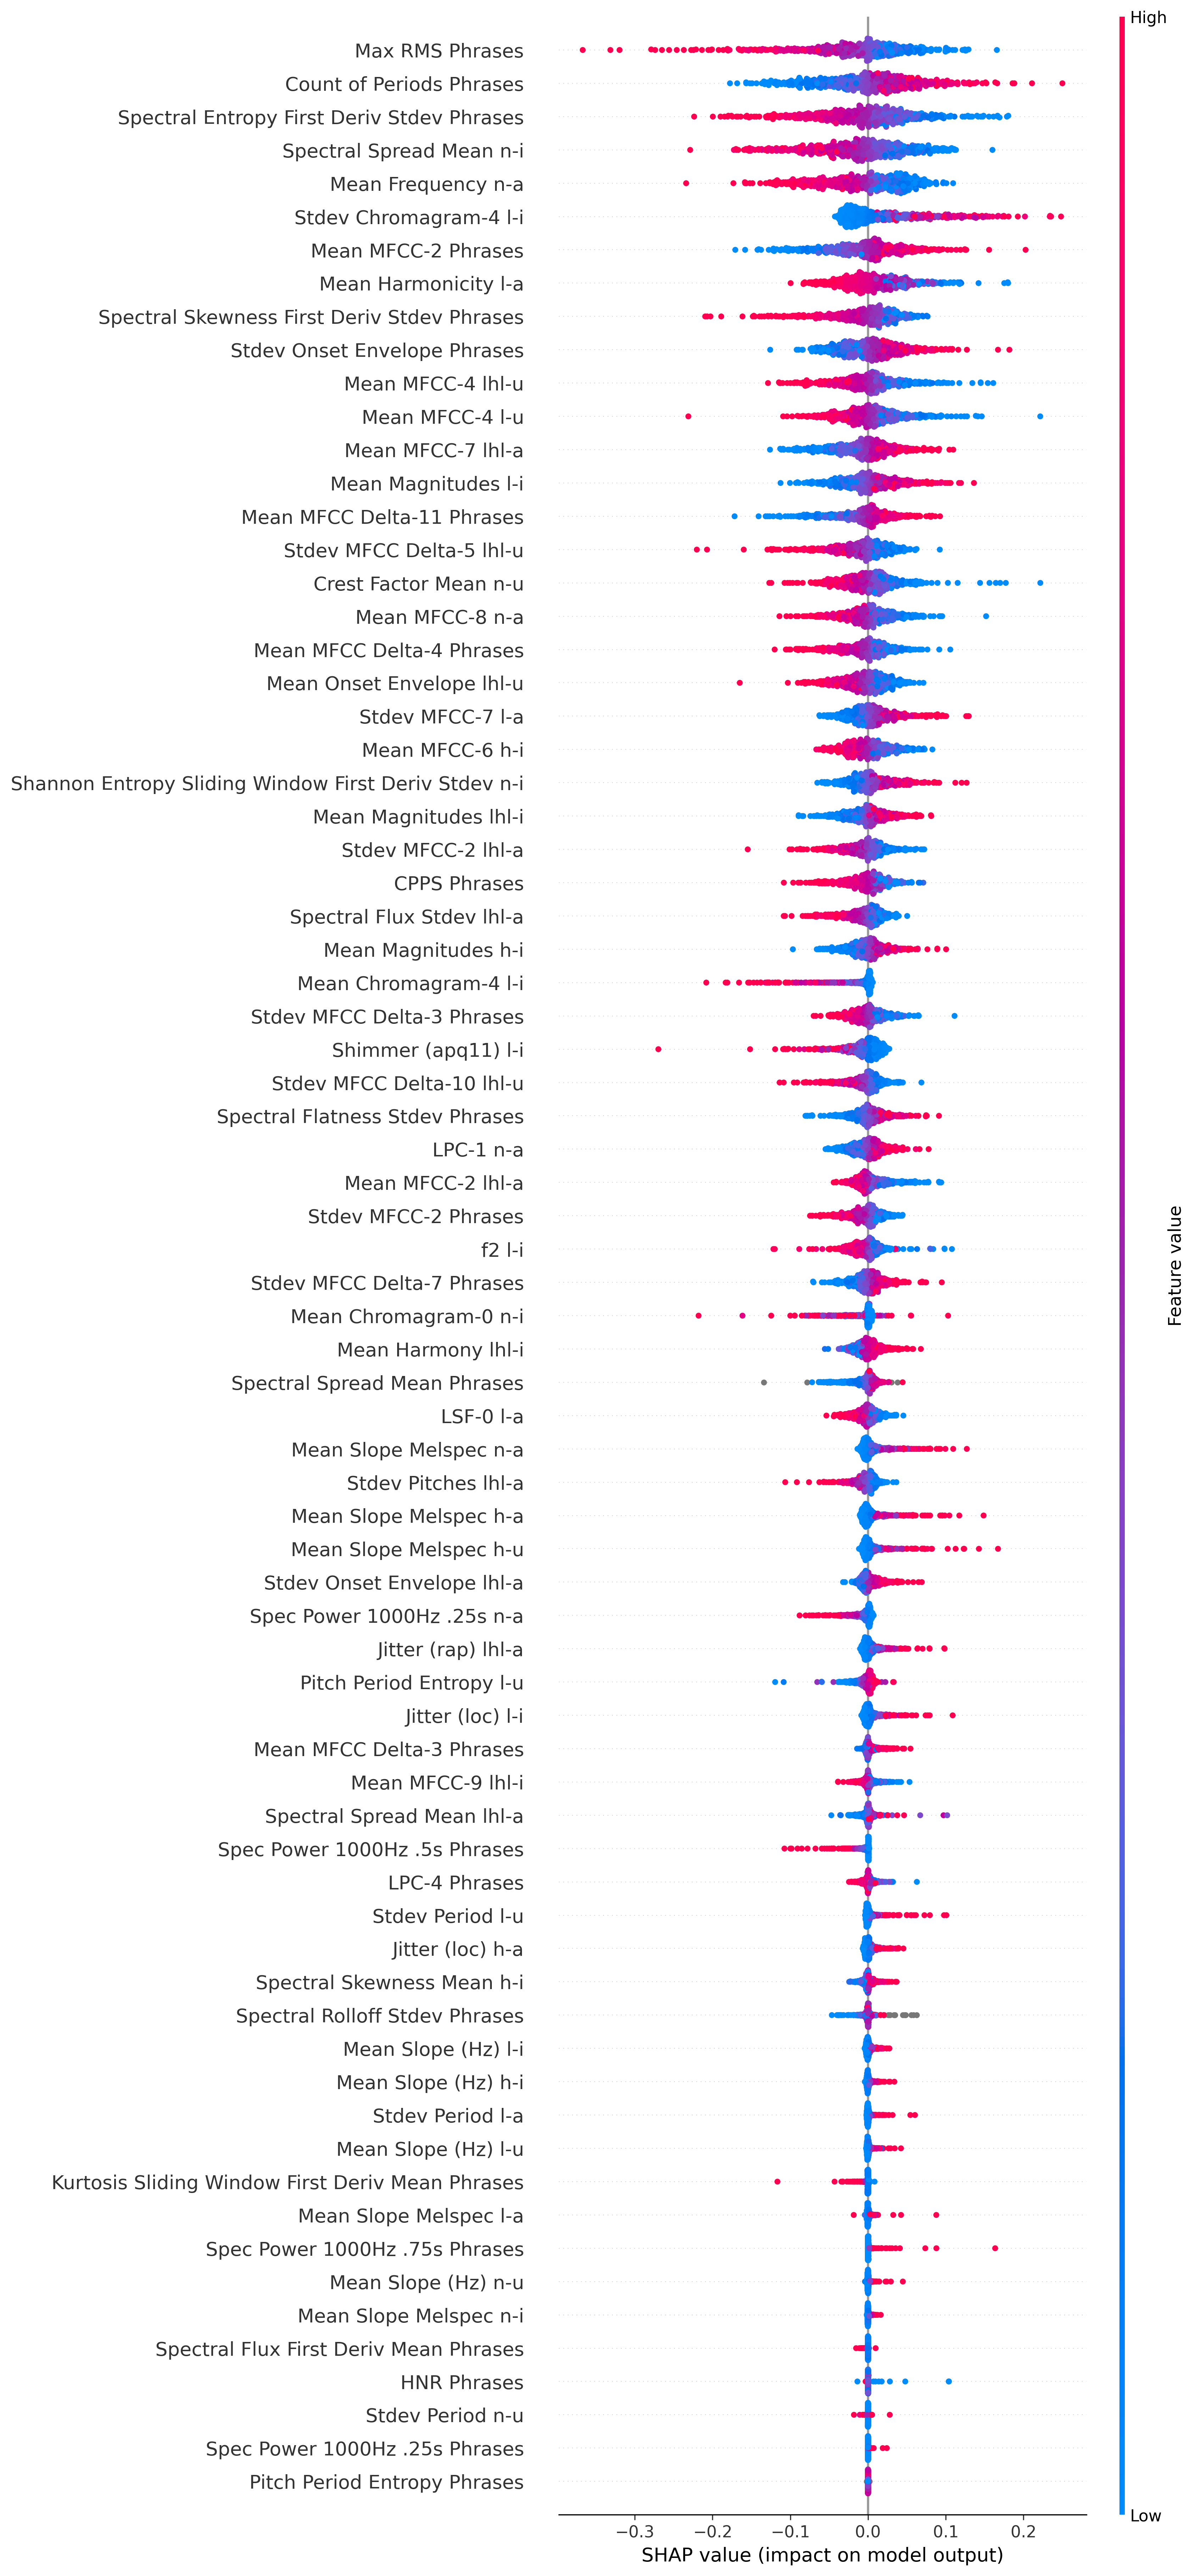

In [16]:
import shap

f = lambda x: tuned_clf.predict_proba(x)[:,1]
med = X_train.median().values.reshape((1,X_train.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(X_test.iloc[:,:])

shap.plots.beeswarm(shap_values)

#### Limit amount of features shown in the plot.

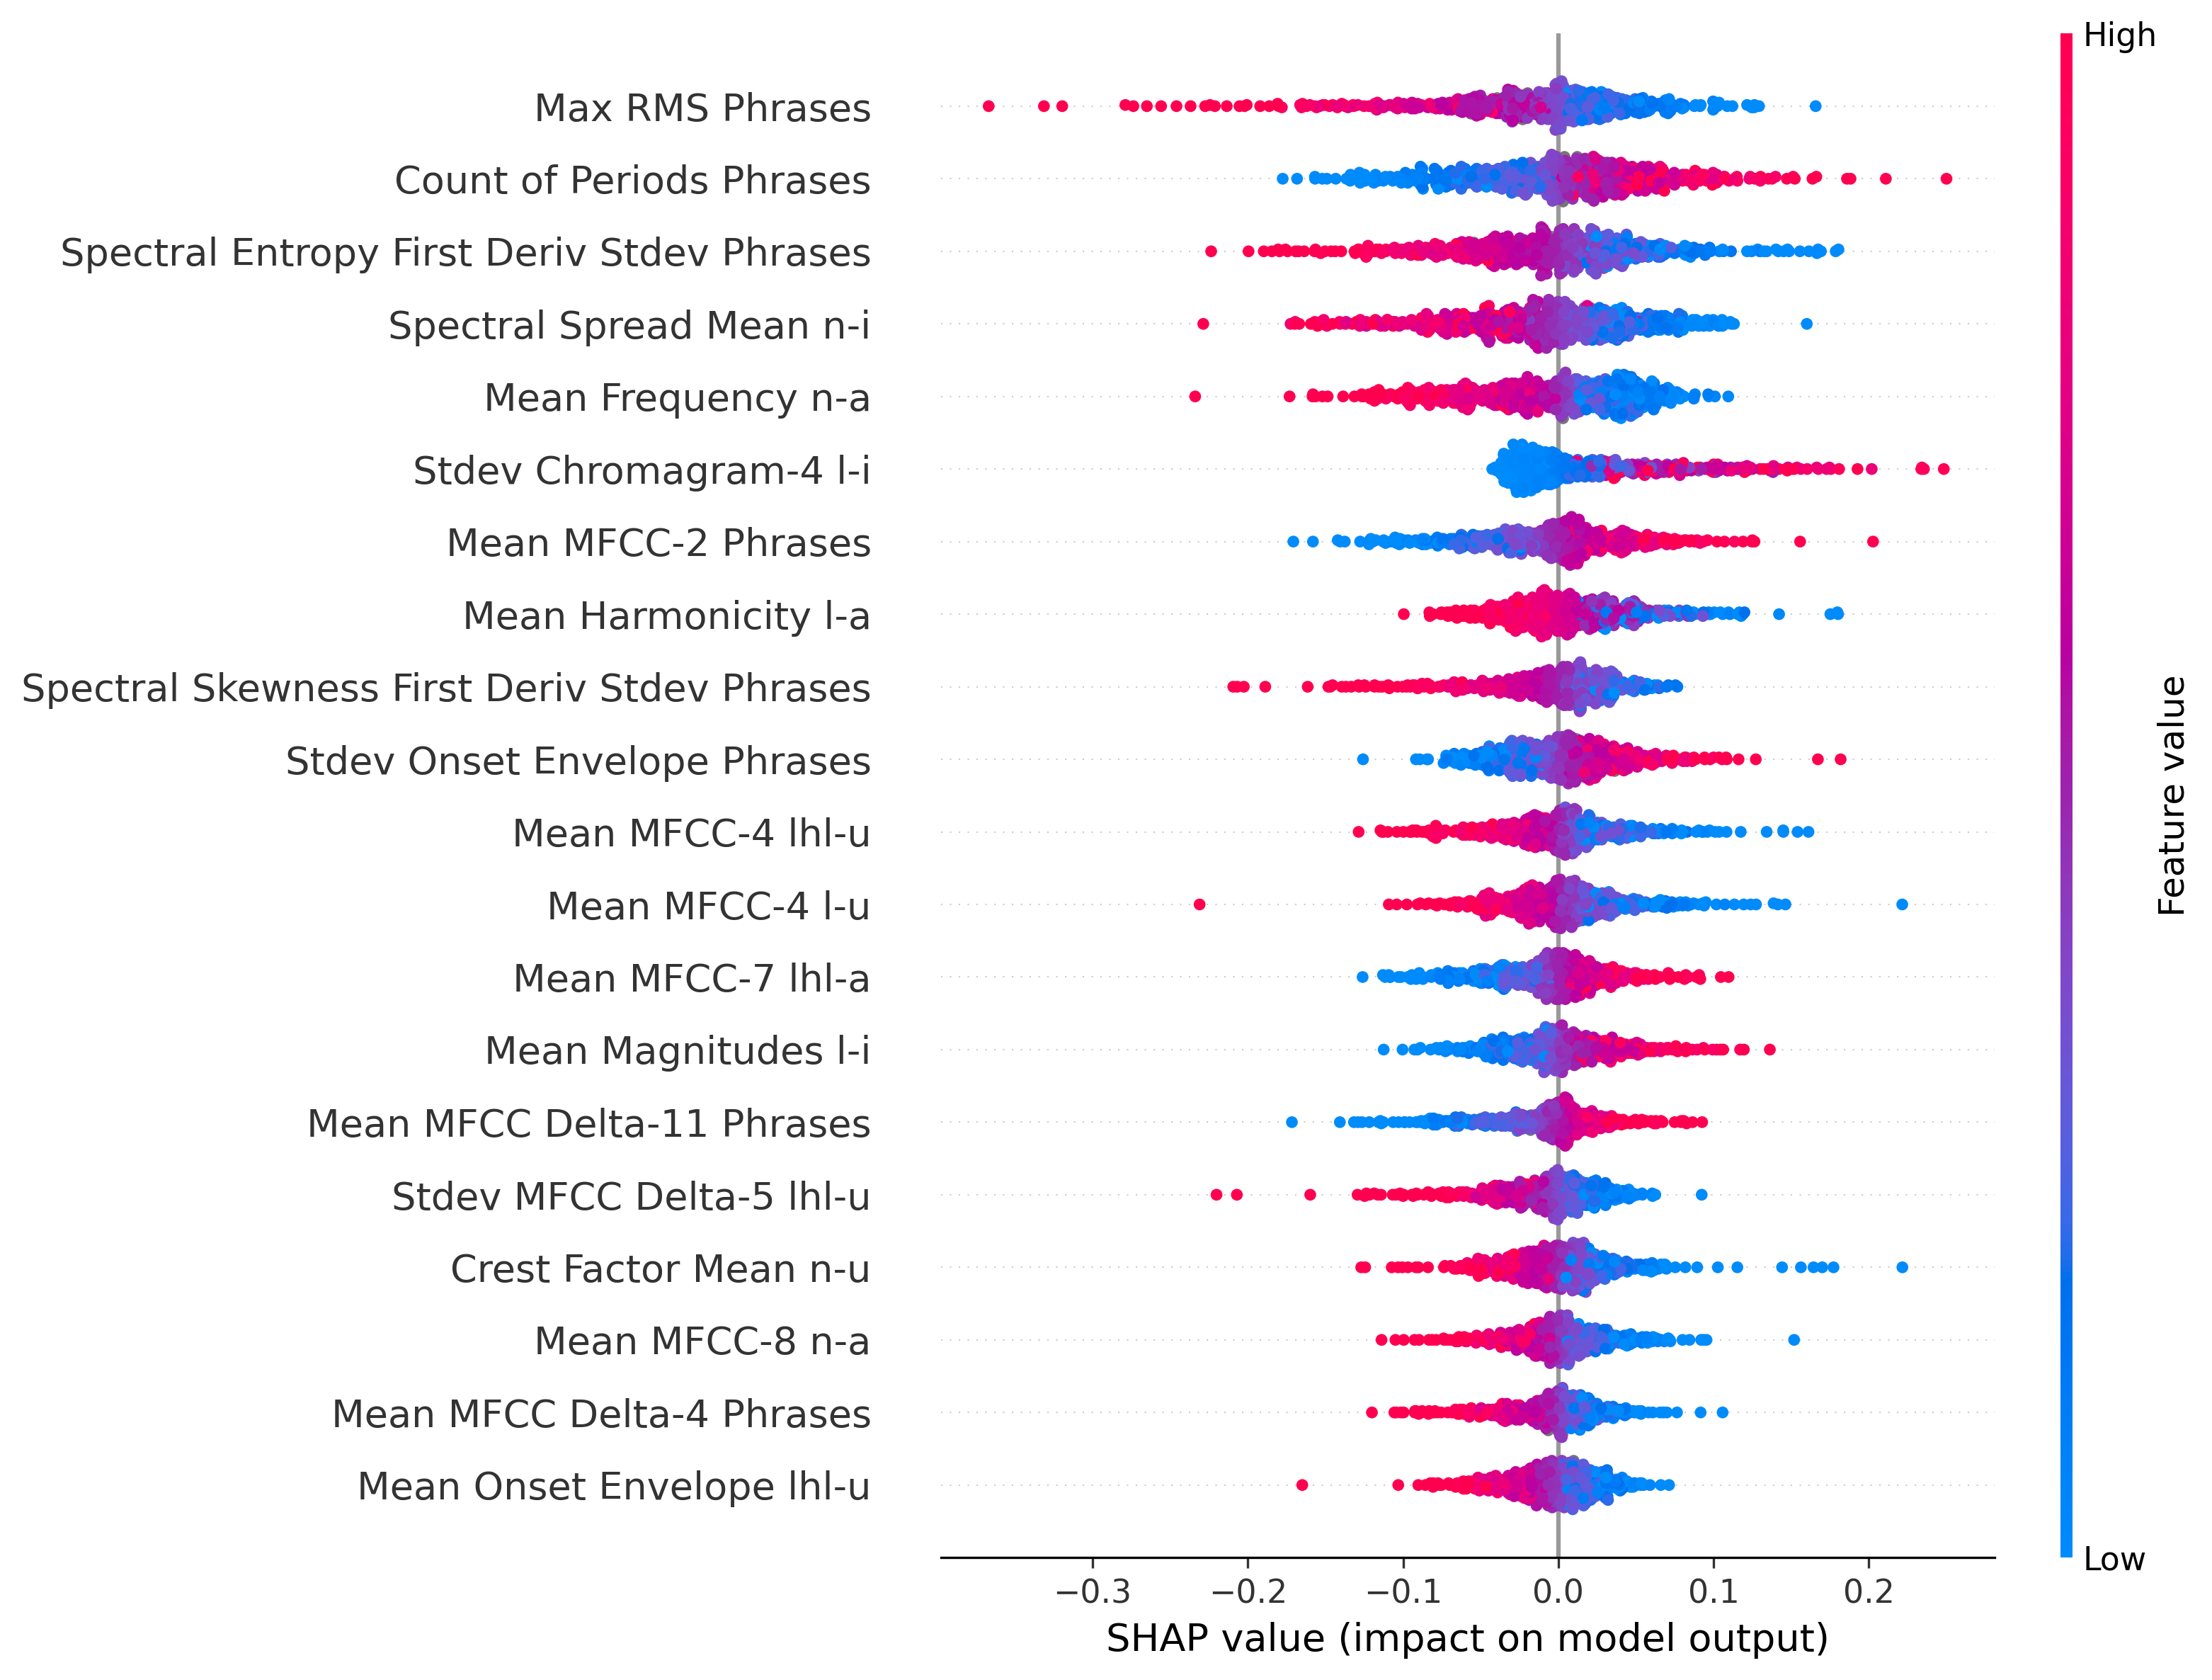

In [17]:
top = ['Max RMS Phrases', 'Count of Periods Phrases', 
      'Spectral Entropy First Deriv Stdev Phrases', 'Spectral Spread Mean n-i',
      'Mean Frequency n-a', 'Stdev Chromagram-4 l-i', 'Mean MFCC-2 Phrases',
      'Mean Harmonicity l-a', 'Spectral Skewness First Deriv Stdev Phrases',
      'Stdev Onset Envelope Phrases', 'Mean MFCC-4 lhl-u', 'Mean MFCC-4 l-u',
      'Mean MFCC-7 lhl-a', 'Mean Magnitudes l-i', 'Mean MFCC Delta-11 Phrases',
      'Stdev MFCC Delta-5 lhl-u', 'Crest Factor Mean n-u', 'Mean MFCC-8 n-a',
      'Mean MFCC Delta-4 Phrases', 'Mean Onset Envelope lhl-u']
top_loc=[X.columns.get_loc(c) for c in top if c in X]
shap.plots.beeswarm(shap_values[:,top_loc])

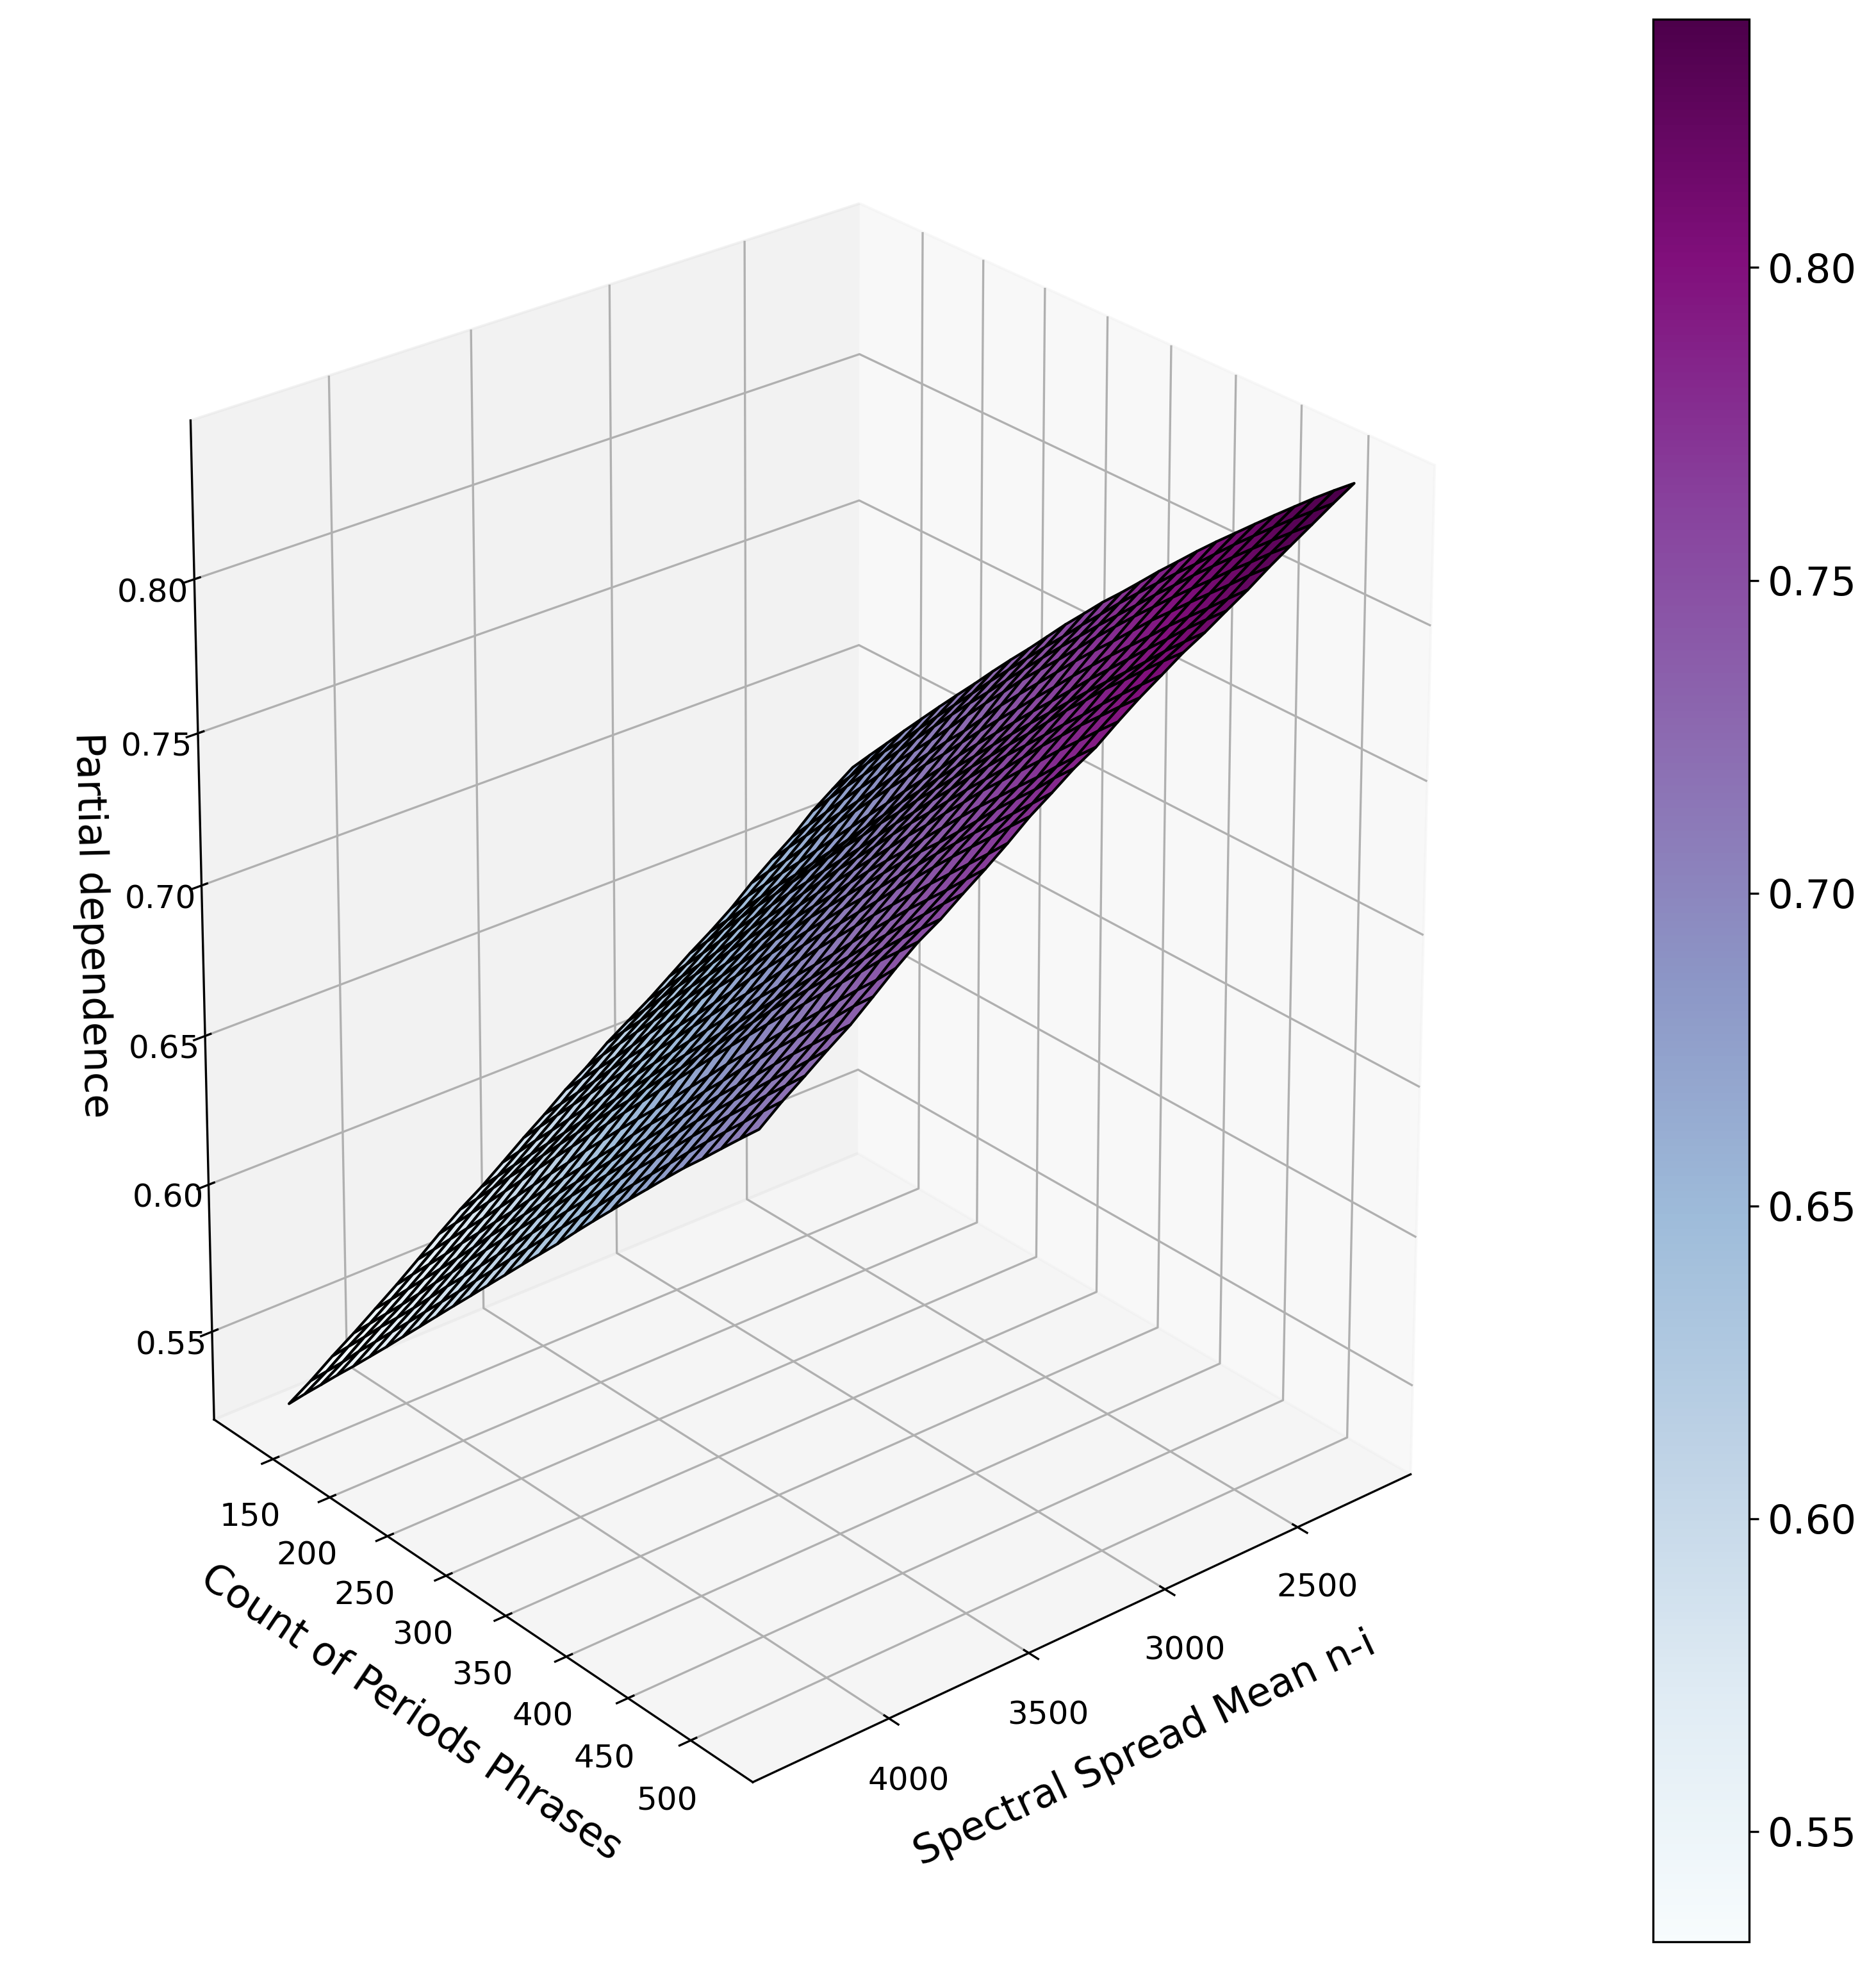

In [18]:
from sklearn.inspection import partial_dependence, plot_partial_dependence
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
rcParams['font.size'] = 15
fig = plt.figure()

features = ('Spectral Spread Mean n-i', 'Count of Periods Phrases')
pdp = partial_dependence(
    tuned_clf, X_test, kind = 'average', features=features, grid_resolution=28
)

XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(features[0], labelpad = 10)
ax.set_ylabel(features[1], labelpad = 10)
ax.set_zlabel('Partial dependence', labelpad = 10)

ax.view_init(elev=22, azim=50)
plt.colorbar(surf)

plt.subplots_adjust(top=0.9)
plt.show()

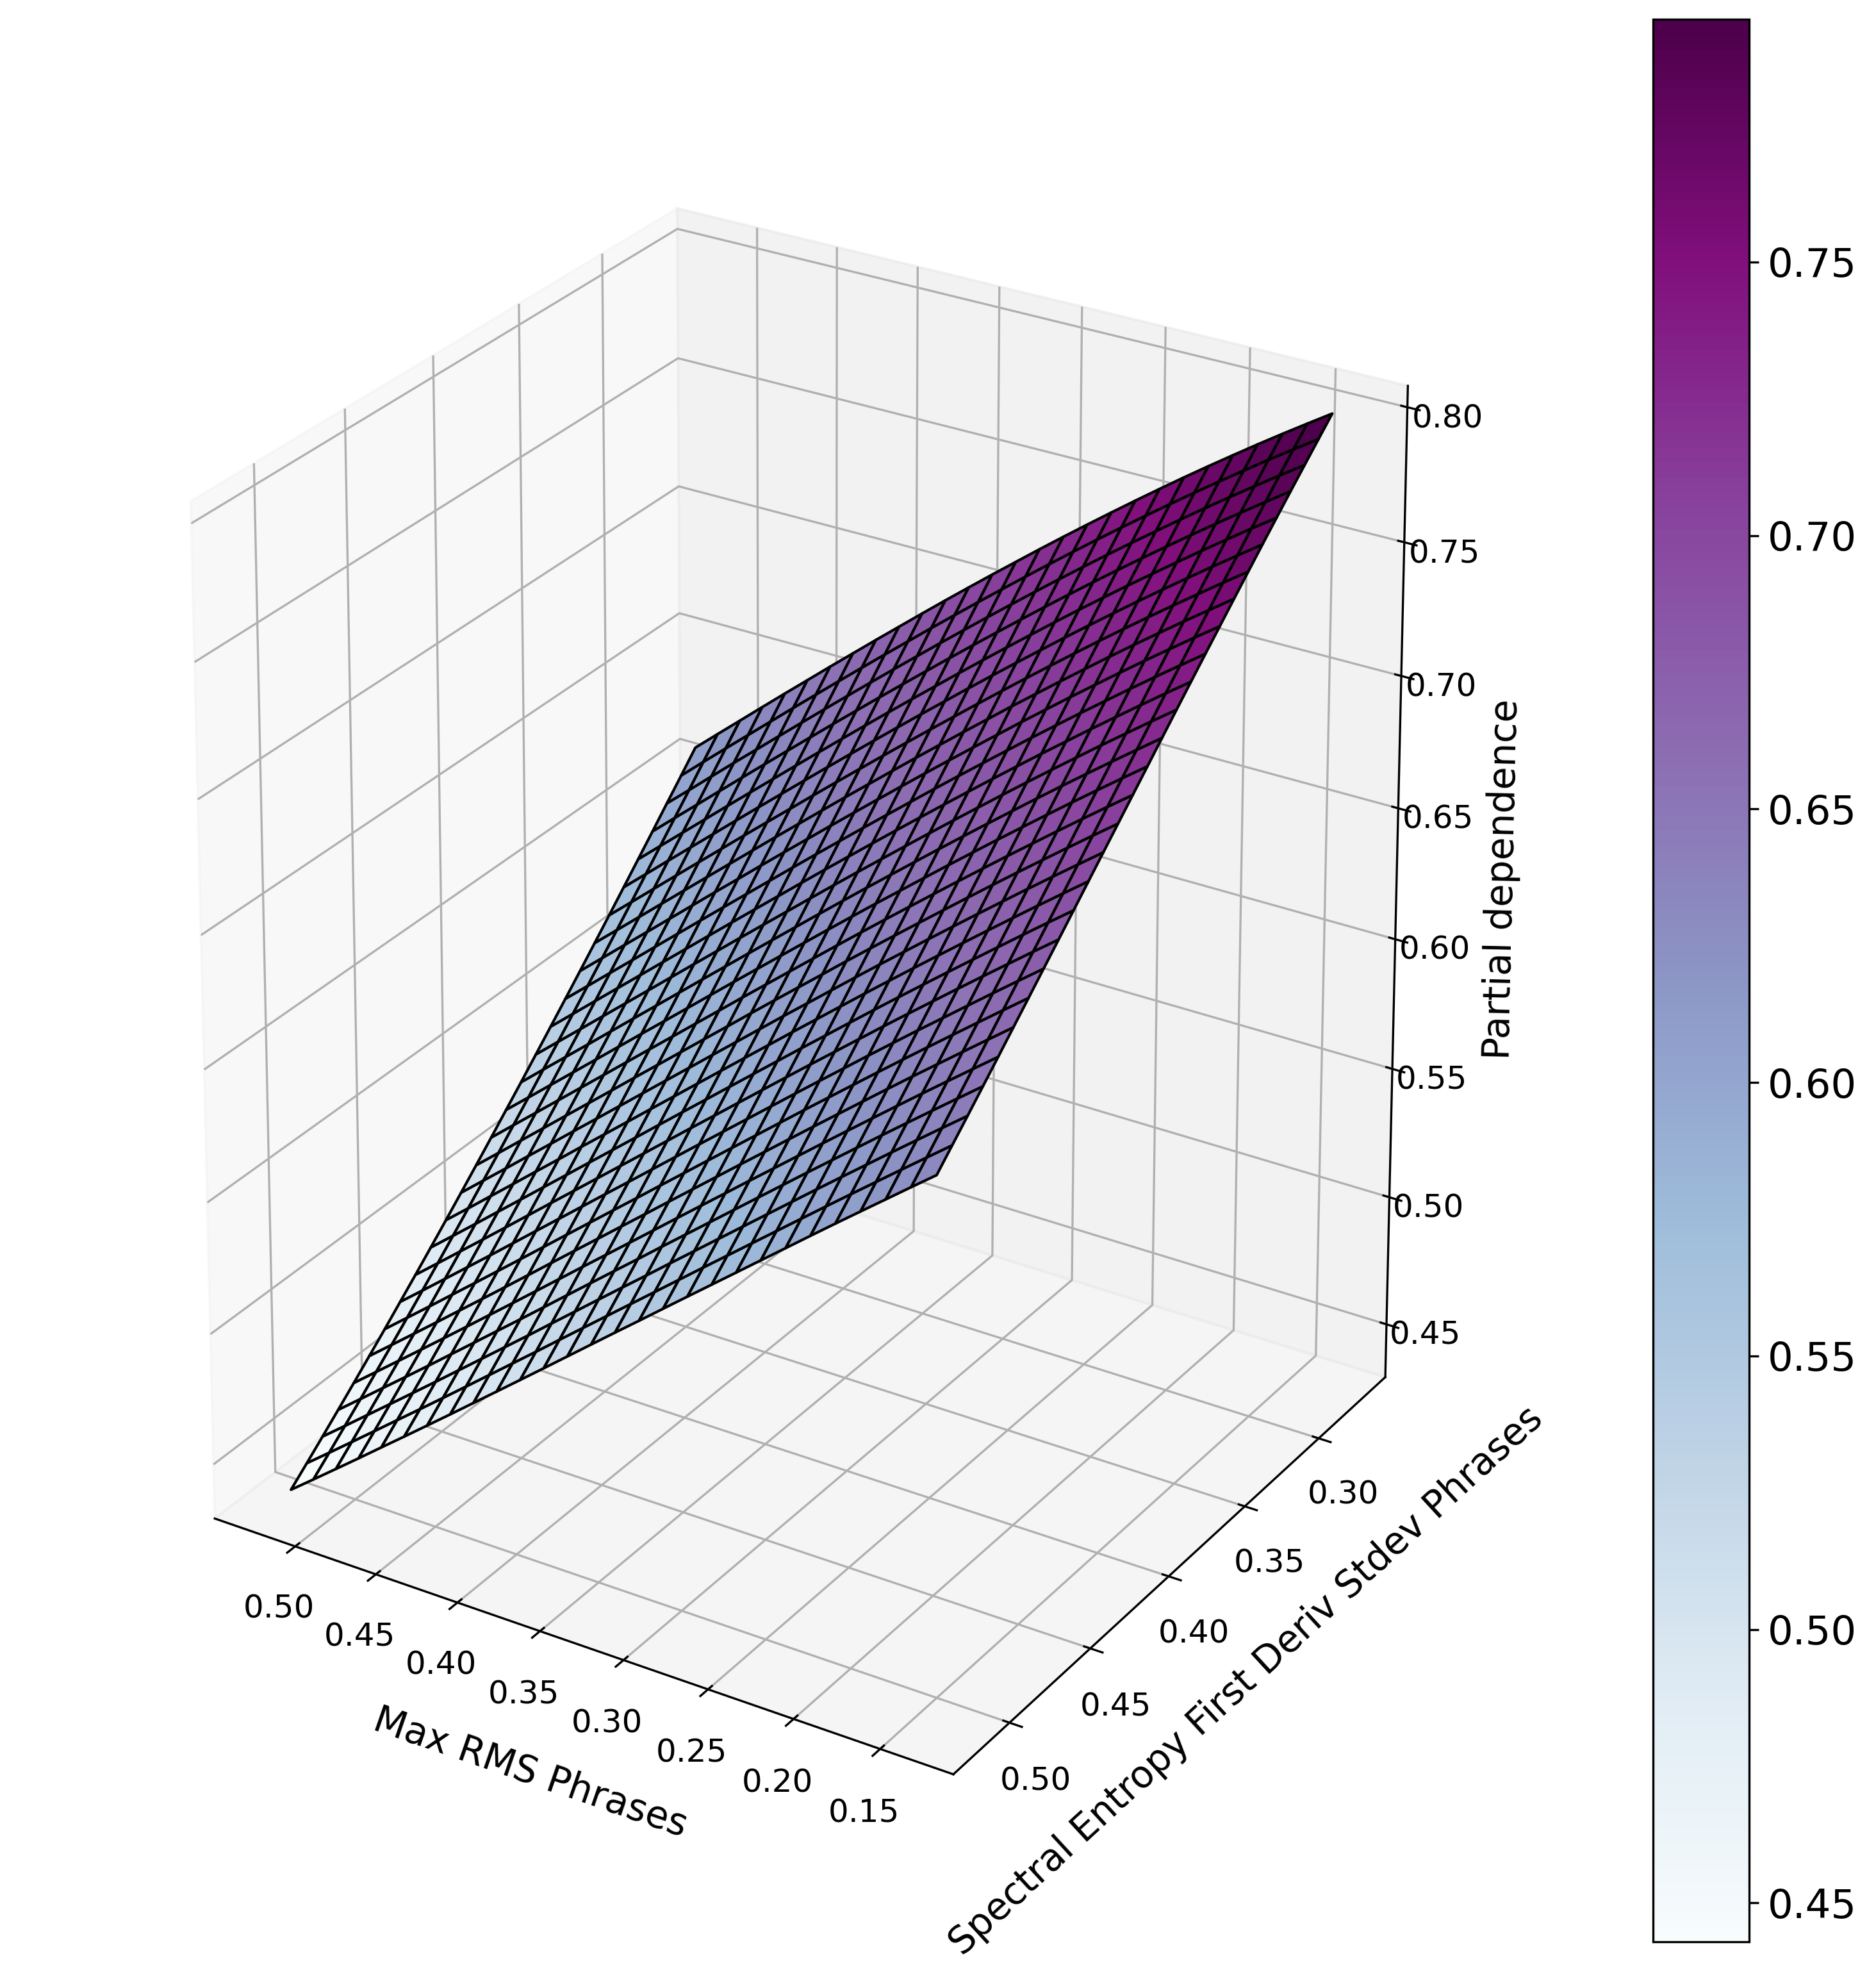

In [19]:
from sklearn.inspection import partial_dependence, plot_partial_dependence
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
rcParams['font.size'] = 14
fig = plt.figure()

features = ('Max RMS Phrases', 'Spectral Entropy First Deriv Stdev Phrases')
pdp = partial_dependence(
    tuned_clf, X_test, kind = 'average', features=features, grid_resolution=28
)

XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(features[0], labelpad = 10)
ax.set_ylabel(features[1], labelpad = 10)
ax.set_zlabel('Partial dependence', labelpad = 10)

ax.view_init(elev=22, azim=122)
plt.colorbar(surf)

plt.subplots_adjust(top=0.9)
plt.show()

#### Evaluate performance of the classifier across demographics variables. Note: Only subsets that included at least 20 instances were kept for this analysis.

In [20]:
X = pd.read_csv(r'C:\Users\esabic\Desktop\Refactor_Attempts_11_4\Raw_Features_Complete_11_19\Complete_Feature_Set_11_19_2.csv')
y, age, sex, recording_num = X['y'], X['age'], X['sex'], X['recording_num']
X = X.drop(['recording_num','y'], axis = 1)

rfecv_subset = pd.read_csv(r'C:\Users\esabic\Desktop\Refactor_Attempts_11_4\Raw_Features_Complete_11_19\RFECV_Results_12_8.csv')
X = X.loc[:, rfecv_subset.columns]

corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
X = X.drop(X[to_drop], axis=1)
print('Total number of features dropped was...', num_feats_after - X.shape[1], '\nRemaining features... ', X.shape[1])
X = X.drop('high_indexphrase_features', axis = 1)

X = pd.concat([X, sex, age], axis = 1)

Total number of features dropped was... 29 
Remaining features...  75


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, stratify = y, random_state = 42)

mask_s0 = (X_test['sex'] == 0)
mask_s1 = (X_test['sex'] == 1)

mask_s0_age_1 = ((X_test['sex'] == 0) & (X_test['age'] == 1)) 
mask_s0_age_2 = ((X_test['sex'] == 0) & (X_test['age'] == 2))
mask_s0_age_3 = ((X_test['sex'] == 0) & (X_test['age'] == 3))
mask_s0_age_4 = ((X_test['sex'] == 0) & (X_test['age'] == 4))
mask_s0_age_5 = ((X_test['sex'] == 0) & (X_test['age'] == 5))
mask_s0_age_6 = ((X_test['sex'] == 0) & (X_test['age'] == 6))
mask_s0_age_7 = ((X_test['sex'] == 0) & (X_test['age'] == 7))

mask_s1_age_2 = ((X_test['sex'] == 1) & (X_test['age'] == 2))
mask_s1_age_3 = ((X_test['sex'] == 1) & (X_test['age'] == 3))
mask_s1_age_4 = ((X_test['sex'] == 1) & (X_test['age'] == 4))
mask_s1_age_5 = ((X_test['sex'] == 1) & (X_test['age'] == 5))
mask_s1_age_6 = ((X_test['sex'] == 1) & (X_test['age'] == 6))
mask_s1_age_7 = ((X_test['sex'] == 1) & (X_test['age'] == 7))

X_train = X_train.drop(['sex','age'], axis = 1)
X_test = X_test.drop(['sex','age'], axis = 1)

In [23]:
from sklearn.metrics import roc_auc_score

print('sex: F, age: 10-19\n', classification_report(y_test[mask_s0_age_1], tuned_clf.predict(X_test[mask_s0_age_1]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s0_age_1], tuned_clf.predict(X_test[mask_s0_age_1])))


sex: F, age: 10-19
               precision    recall  f1-score   support

      benign     0.9545    0.8077    0.8750        26
   anomalous     0.2857    0.6667    0.4000         3

    accuracy                         0.7931        29
   macro avg     0.6201    0.7372    0.6375        29
weighted avg     0.8854    0.7931    0.8259        29

0.7371794871794871


In [24]:
print('sex: F, age: 20-29\n', classification_report(y_test[mask_s0_age_2], tuned_clf.predict(X_test[mask_s0_age_2]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s0_age_2], tuned_clf.predict(X_test[mask_s0_age_2])))


sex: F, age: 20-29
               precision    recall  f1-score   support

      benign     0.8333    0.8427    0.8380        89
   anomalous     0.5758    0.5588    0.5672        34

    accuracy                         0.7642       123
   macro avg     0.7045    0.7008    0.7026       123
weighted avg     0.7621    0.7642    0.7631       123

0.700760079312624


In [25]:
print('sex: F, age: 30-39\n', classification_report(y_test[mask_s0_age_3], tuned_clf.predict(X_test[mask_s0_age_3]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s0_age_3], tuned_clf.predict(X_test[mask_s0_age_3])))

sex: F, age: 30-39
               precision    recall  f1-score   support

      benign     0.5000    0.5000    0.5000         6
   anomalous     0.9189    0.9189    0.9189        37

    accuracy                         0.8605        43
   macro avg     0.7095    0.7095    0.7095        43
weighted avg     0.8605    0.8605    0.8605        43

0.7094594594594594


In [26]:
print('sex: F, age: 40-49\n', classification_report(y_test[mask_s0_age_4], tuned_clf.predict(X_test[mask_s0_age_4]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s0_age_4], tuned_clf.predict(X_test[mask_s0_age_4])))

sex: F, age: 40-49
               precision    recall  f1-score   support

      benign     0.1429    0.2500    0.1818         4
   anomalous     0.9143    0.8421    0.8767        38

    accuracy                         0.7857        42
   macro avg     0.5286    0.5461    0.5293        42
weighted avg     0.8408    0.7857    0.8105        42

0.5460526315789473


In [27]:
print('sex: F, age: 50-59\n', classification_report(y_test[mask_s0_age_5], tuned_clf.predict(X_test[mask_s0_age_5]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s0_age_5], tuned_clf.predict(X_test[mask_s0_age_5])))

sex: F, age: 50-59
               precision    recall  f1-score   support

      benign     0.0000    0.0000    0.0000         4
   anomalous     0.9200    0.9583    0.9388        48

    accuracy                         0.8846        52
   macro avg     0.4600    0.4792    0.4694        52
weighted avg     0.8492    0.8846    0.8666        52

0.4791666666666667


In [28]:
print('sex: F, age: 60-69\n', classification_report(y_test[mask_s0_age_6], tuned_clf.predict(X_test[mask_s0_age_6]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s0_age_6], tuned_clf.predict(X_test[mask_s0_age_6])))

sex: F, age: 60-69
               precision    recall  f1-score   support

      benign     0.0000    0.0000    0.0000         1
   anomalous     0.9744    0.9500    0.9620        40

    accuracy                         0.9268        41
   macro avg     0.4872    0.4750    0.4810        41
weighted avg     0.9506    0.9268    0.9386        41

0.475


In [29]:
print('sex: F, age: 70-79\n', classification_report(y_test[mask_s0_age_7], tuned_clf.predict(X_test[mask_s0_age_7]), target_names = ['anomalous'], digits = 4))

sex: F, age: 70-79
               precision    recall  f1-score   support

   anomalous     1.0000    1.0000    1.0000        23

    accuracy                         1.0000        23
   macro avg     1.0000    1.0000    1.0000        23
weighted avg     1.0000    1.0000    1.0000        23



In [30]:
print('sex: M, age: 20-29\n', classification_report(y_test[mask_s1_age_2], tuned_clf.predict(X_test[mask_s1_age_2]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s1_age_2], tuned_clf.predict(X_test[mask_s1_age_2])))

sex: M, age: 20-29
               precision    recall  f1-score   support

      benign     0.9032    0.6222    0.7368        45
   anomalous     0.2273    0.6250    0.3333         8

    accuracy                         0.6226        53
   macro avg     0.5652    0.6236    0.5351        53
weighted avg     0.8012    0.6226    0.6759        53

0.6236111111111111


In [31]:
print('sex: M, age: 30-39\n', classification_report(y_test[mask_s1_age_3], tuned_clf.predict(X_test[mask_s1_age_3]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s1_age_3], tuned_clf.predict(X_test[mask_s1_age_3])))

sex: M, age: 30-39
               precision    recall  f1-score   support

      benign     0.6667    0.7143    0.6897        14
   anomalous     0.7500    0.7059    0.7273        17

    accuracy                         0.7097        31
   macro avg     0.7083    0.7101    0.7085        31
weighted avg     0.7124    0.7097    0.7103        31

0.7100840336134454


In [32]:
print('sex: M, age: 40-49\n', classification_report(y_test[mask_s1_age_4], tuned_clf.predict(X_test[mask_s1_age_4]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s1_age_4], tuned_clf.predict(X_test[mask_s1_age_4])))

sex: M, age: 40-49
               precision    recall  f1-score   support

      benign     0.6667    1.0000    0.8000         6
   anomalous     1.0000    0.8800    0.9362        25

    accuracy                         0.9032        31
   macro avg     0.8333    0.9400    0.8681        31
weighted avg     0.9355    0.9032    0.9098        31

0.94


In [33]:
print('sex: M, age: 50-59\n', classification_report(y_test[mask_s1_age_5], tuned_clf.predict(X_test[mask_s1_age_5]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s1_age_5], tuned_clf.predict(X_test[mask_s1_age_5])))

sex: M, age: 50-59
               precision    recall  f1-score   support

      benign     0.4000    0.4000    0.4000         5
   anomalous     0.9400    0.9400    0.9400        50

    accuracy                         0.8909        55
   macro avg     0.6700    0.6700    0.6700        55
weighted avg     0.8909    0.8909    0.8909        55

0.6699999999999999


In [34]:
print('sex: M, age: 60-69\n', classification_report(y_test[mask_s1_age_6], tuned_clf.predict(X_test[mask_s1_age_6]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s1_age_6], tuned_clf.predict(X_test[mask_s1_age_6])))

sex: M, age: 60-69
               precision    recall  f1-score   support

      benign     0.0000    0.0000    0.0000         2
   anomalous     0.9600    0.9600    0.9600        50

    accuracy                         0.9231        52
   macro avg     0.4800    0.4800    0.4800        52
weighted avg     0.9231    0.9231    0.9231        52

0.48


In [35]:
print('sex: M, age: 70-79, note: only 1 class has support\n', classification_report(y_test[mask_s1_age_7], tuned_clf.predict(X_test[mask_s1_age_7]), digits = 4))

sex: M, age: 70-79, note: only 1 class has support
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     1.0000    0.9600    0.9796        25

    accuracy                         0.9600        25
   macro avg     0.5000    0.4800    0.4898        25
weighted avg     1.0000    0.9600    0.9796        25



Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [36]:
print('sex: F\n', classification_report(y_test[mask_s0], tuned_clf.predict(X_test[mask_s0]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s0], tuned_clf.predict(X_test[mask_s0])))

sex: F
               precision    recall  f1-score   support

      benign     0.7752    0.7634    0.7692       131
   anomalous     0.8628    0.8705    0.8667       224

    accuracy                         0.8310       355
   macro avg     0.8190    0.8169    0.8179       355
weighted avg     0.8305    0.8310    0.8307       355

0.8169472464558343


In [37]:
print('sex: M\n', classification_report(y_test[mask_s1], tuned_clf.predict(X_test[mask_s1]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s1], tuned_clf.predict(X_test[mask_s1])))

sex: M
               precision    recall  f1-score   support

      benign     0.7206    0.6533    0.6853        75
   anomalous     0.8624    0.8956    0.8787       182

    accuracy                         0.8249       257
   macro avg     0.7915    0.7745    0.7820       257
weighted avg     0.8210    0.8249    0.8223       257

0.7744688644688644


### Pickle the model for later use.

In [38]:
import pickle

pkl_filename = "SVM_1_25_.pkl"

with open(pkl_filename, 'wb') as file:
    pickle.dump(tuned_clf, file)